# Part 1 - DEFINE
### --- 1 Define the problem ---
#### To predict Home Credit client's probability of default based on client's data

In [126]:
# import libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Part 2 - Discover
### --- 2.1 Load the data ---

In [2]:
# define a function to compress numeric types and convert objects to strings so that memory usage is reduced
def reduce_mem_use(df):
    '''iterate thru columns to modify data type in order to reduce memory usage'''
    conv_rate = 1024**2 # byte to megabyte
    start_mem = df.memory_usage().sum() / conv_rate
    print('Start memory is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
        else:
            df[col] = df[col].astype('category')
        
    end_mem = df.memory_usage().sum() / conv_rate
    print('Memory usage after optimization is: {:.2f} MB, {:.1f}% reduction rate'.format(end_mem, 
                                                            100*(start_mem-end_mem)/start_mem))
    
    return df

def import_data(file):
    '''Use memory size optimization and chunk size to efficiently import data'''
    chunk = pd.read_csv(file, parse_dates=True, keep_date_col=True, chunksize=10000)
    df = pd.concat(chunk)
    df = reduce_mem_use(df)
    return df

In [3]:
# display all columns (i.e. no limit to column width)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [4]:
# load the data into pandas dataframe
# might need to read file in chunksize due to large size
app_train = import_data('application_train.csv')
app_train.info()
app_train.head()
app_train.describe()

Start memory is 286.23 MB
Memory usage after optimization is: 59.54 MB, 79.2% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float16(61), float32(4), int16(2), int32(2), int8(37)
memory usage: 59.5 MB


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.0,306490.0,306490.0,306490.0,307510.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.0,265992.0,265992.0,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,NaN,-2994.202373,NaN,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.0,NaN,0.00

In [5]:
app_test = import_data('application_test.csv')
app_test.info()
app_test.head()
app_test.describe()

Start memory is 45.00 MB
Memory usage after optimization is: 9.40 MB, 79.1% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float16(61), float32(4), int16(2), int32(2), int8(36)
memory usage: 9.4 MB


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,1.643200e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.0,48715.000000,48715.0,48715.000000,48744.00,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,4.269500e+04
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.238281,4.626188e+05,0.021240,-16068.084605,67485.366322,-inf,-3051.712949,inf,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,inf,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.500977,0.518555,0.500000,0.122375,0.090027,0.979004,0.750977,0.047607,0.085144,0.151733,0.233643,0.238281,0.067200,0.105835,0.112305,0.009239,0.029373,0.119019,0.089050,0.977539,0.757812,0.045227,0.080566,0.147217,0.229370,0.233765,0.065918,0.110901,0.110718,0.008354,0.028168,0.122742,0.089539,0.979004,0.754395,0.047424,0.084106,0.151123,0.233154,0.237793,0.068054,0.107056,0.113403,0.008980,0.029312,0.107239,inf,0.143677,inf,0.101196,-inf,0.0,0.786620,0.000103,0.014751,0.087477,0.000041,0.088462,0.004493,0.

#### It looks like just the training file already has over 100 features.

In [6]:
# previous application data
pre_app = import_data('previous_application.csv')
pre_app.info()
pre_app.head()

Start memory is 471.48 MB
Memory usage after optimization is: 130.62 MB, 72.3% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int32   
 1   SK_ID_CURR                   1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE           1670214 non-null  category
 3   AMT_ANNUITY                  1297979 non-null  float32 
 4   AMT_APPLICATION              1670214 non-null  float32 
 5   AMT_CREDIT                   1670213 non-null  float32 
 6   AMT_DOWN_PAYMENT             774370 non-null   float32 
 7   AMT_GOODS_PRICE              1284699 non-null  float32 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  category
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  category


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# bureau data
bureau = import_data('bureau.csv')
bureau.info()
bureau.head()

Start memory is 222.62 MB
Memory usage after optimization is: 78.57 MB, 64.7% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   SK_ID_CURR              int32   
 1   SK_ID_BUREAU            int32   
 2   CREDIT_ACTIVE           category
 3   CREDIT_CURRENCY         category
 4   DAYS_CREDIT             int16   
 5   CREDIT_DAY_OVERDUE      int16   
 6   DAYS_CREDIT_ENDDATE     float16 
 7   DAYS_ENDDATE_FACT       float16 
 8   AMT_CREDIT_MAX_OVERDUE  float32 
 9   CNT_CREDIT_PROLONG      int8    
 10  AMT_CREDIT_SUM          float32 
 11  AMT_CREDIT_SUM_DEBT     float32 
 12  AMT_CREDIT_SUM_LIMIT    float32 
 13  AMT_CREDIT_SUM_OVERDUE  float32 
 14  CREDIT_TYPE             category
 15  DAYS_CREDIT_UPDATE      int32   
 16  AMT_ANNUITY             float32 
dtypes: category(3), float16(2), float32(6), int16(2), int32(3), int8(1)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
# bureau balance data
bureau_bal = import_data('bureau_balance.csv')
bureau_bal.info()
bureau_bal.head()

Start memory is 624.85 MB
Memory usage after optimization is: 156.21 MB, 75.0% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype   
---  ------          -----   
 0   SK_ID_BUREAU    int32   
 1   MONTHS_BALANCE  int8    
 2   STATUS          category
dtypes: category(1), int32(1), int8(1)
memory usage: 156.2 MB


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [9]:
# point of sale cash balance data
pos_bal = import_data('POS_CASH_balance.csv')
pos_bal.info()
pos_bal.head()

Start memory is 610.43 MB
Memory usage after optimization is: 171.69 MB, 71.9% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   SK_ID_PREV             int32   
 1   SK_ID_CURR             int32   
 2   MONTHS_BALANCE         int8    
 3   CNT_INSTALMENT         float16 
 4   CNT_INSTALMENT_FUTURE  float16 
 5   NAME_CONTRACT_STATUS   category
 6   SK_DPD                 int16   
 7   SK_DPD_DEF             int16   
dtypes: category(1), float16(2), int16(2), int32(2), int8(1)
memory usage: 171.7 MB


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [10]:
# installment payments data
install_pay = import_data('installments_payments.csv')
install_pay.info()
install_pay.head()

Start memory is 830.41 MB
Memory usage after optimization is: 311.40 MB, 62.5% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float16
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float16
 5   DAYS_ENTRY_PAYMENT      float16
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [11]:
# credit card balance data
credit_bal = import_data('credit_card_balance.csv')
credit_bal.info()
credit_bal.head()

Start memory is 673.88 MB
Memory usage after optimization is: 263.69 MB, 60.9% reduction rate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   SK_ID_PREV                  int32   
 1   SK_ID_CURR                  int32   
 2   MONTHS_BALANCE              int8    
 3   AMT_BALANCE                 float32 
 4   AMT_CREDIT_LIMIT_ACTUAL     int32   
 5   AMT_DRAWINGS_ATM_CURRENT    float32 
 6   AMT_DRAWINGS_CURRENT        float32 
 7   AMT_DRAWINGS_OTHER_CURRENT  float32 
 8   AMT_DRAWINGS_POS_CURRENT    float32 
 9   AMT_INST_MIN_REGULARITY     float32 
 10  AMT_PAYMENT_CURRENT         float32 
 11  AMT_PAYMENT_TOTAL_CURRENT   float32 
 12  AMT_RECEIVABLE_PRINCIPAL    float32 
 13  AMT_RECIVABLE               float32 
 14  AMT_TOTAL_RECEIVABLE        float32 
 15  CNT_DRAWINGS_ATM_CURRENT    float16 
 16  CNT_DRAWINGS_CURRENT        int1

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [12]:
# list all dataframes and get a sense of the sizes
print('application_train has {:,} rows and {} columns'.format(app_train.shape[0], app_train.shape[1]))
print('previous_application has {:,} rows and {} columns'.format(pre_app.shape[0], pre_app.shape[1]))
print('bureau has {:,} rows and {} columns'.format(bureau.shape[0], bureau.shape[1]))
print('bureau_balance has {:,} rows and {} columns'.format(bureau_bal.shape[0], bureau_bal.shape[1]))
print('POS_CASH_balance has {:,} rows and {} columns'.format(pos_bal.shape[0], pos_bal.shape[1]))
print('installments_payments has {:,} rows and {} columns'.format(install_pay.shape[0], install_pay.shape[1]))
print('credit_card_balance has {:,} rows and {} columns'.format(credit_bal.shape[0], credit_bal.shape[1]))

application_train has 307,511 rows and 122 columns
previous_application has 1,670,214 rows and 37 columns
bureau has 1,716,428 rows and 17 columns
bureau_balance has 27,299,925 rows and 3 columns
POS_CASH_balance has 10,001,358 rows and 8 columns
installments_payments has 13,605,401 rows and 8 columns
credit_card_balance has 3,840,312 rows and 23 columns


#### The dataset for this project is large in terms of number of rows and columns, beyond what human brain can process. 
#### In order to potentially include all the important features in the ML model, it might be worth to try joining all data together by keys such as SK_ID_CURR and SK_ID_PREV. 
#### Before doing that, we can attempt to aggregate some data frames that have large number of rows such as bureau balance, POS balance and installment payment

### --- 2.2 Data wrangling ---
#### 2.2.1 bureau data

In [13]:
print(len(bureau_bal['SK_ID_BUREAU']))
print(bureau_bal['SK_ID_BUREAU'].nunique())

27299925
817395


In [14]:
# aggregate monthly balance by ID and status
bb_group = bureau_bal.groupby('SK_ID_BUREAU').mean().reset_index()
bb_group.head()

,SK_ID_BUREAU,MONTHS_BALANCE
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [15]:
# change column names in the bureau balance dataframe
bb_group = bb_group.rename(columns = {'MONTHS_BALANCE': 'bb_MONTHS_BALANCE'}, inplace = False)

In [16]:
bb_group.head()

,SK_ID_BUREAU,bb_MONTHS_BALANCE
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [17]:
print(len(bureau['SK_ID_BUREAU']))
print(bureau['SK_ID_BUREAU'].nunique())

1716428
1716428


#### It seems the dataset bureau no duplicate record over the column SK_ID_BUREAU, can use this key to join to the bureau balance table

In [18]:
# first check how many columns of the tables are overlapped
set(bureau.columns).intersection(set(bureau_bal.columns))

{'SK_ID_BUREAU'}

#### After aggregating, now there is a way to efficiently join data

In [19]:
# use dask library (parallel computing) to join bureau and bureau balance agg dataframes, keep all columns
bureau_merge = dd.merge(left=bureau, right=bb_group, how='left', on='SK_ID_BUREAU')

In [20]:
bureau_merge.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bb_MONTHS_BALANCE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


#### previous application, POS_CASH_balance, installments_payments and credit card balance all have current ID and previous ID

#### 2.2.2  installments payments, credit balance and POS cash balance

In [21]:
# find a way to aggregate installment payments as one current ID corresponds to many previous ID
install_group = install_pay.groupby(['SK_ID_CURR']).mean().reset_index()
install_group.columns = ['install_'+str(col) for col in install_group.columns]
install_group.rename(columns = {'install_SK_ID_CURR':'SK_ID_CURR'}, inplace = True) 

In [22]:
install_group.head()

,SK_ID_CURR,install_SK_ID_PREV,install_NUM_INSTALMENT_VERSION,install_NUM_INSTALMENT_NUMBER,install_DAYS_INSTALMENT,install_DAYS_ENTRY_PAYMENT,install_AMT_INSTALMENT,install_AMT_PAYMENT
0,100001,1.576389e+06,1.142578,2.714286,-2188.0,-2196.0,5885.132324,5885.132324
1,100002,1.038818e+06,1.052734,10.000000,-295.0,-315.5,11559.247070,11559.247070
2,100003,2.290070e+06,1.040039,5.080000,-1378.0,-1385.0,64754.585938,64754.585938
3,100004,1.564014e+06,1.333008,2.000000,-754.0,-761.5,7096.154785,7096.154785
4,100005,2.495675e+06,1.111328,5.000000,-586.0,-609.5,6240.205078,6240.205078


In [23]:
# adopt the same step for credit card balance
credit_group = credit_bal.groupby(['SK_ID_CURR']).mean().reset_index()
credit_group.columns = ['cc_'+str(col) for col in credit_group.columns]
credit_group.rename(columns = {'cc_SK_ID_CURR':'SK_ID_CURR'}, inplace = True) 
credit_group.head()

,SK_ID_CURR,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF
0,100006,1489396.0,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
1,100011,1843384.0,-38.5,54482.109375,164189.189189,2432.432373,2432.432373,0.0,0.0,3956.221924,4843.063965,4520.067383,52402.089844,54433.179688,54433.179688,0.054047,0.054054,0.0,0.0,25.765625,0.000000,0.000000
2,100013,2038692.0,-48.5,18159.919922,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346191,6817.172363,17255.560547,18101.080078,18101.080078,0.255615,0.239583,0.0,0.0,18.718750,0.010417,0.010417
3,100021,2594025.0,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
4,100023,1499902.0,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000


In [24]:
# same step for point of sale cash balance
pos_group = pos_bal.groupby(['SK_ID_CURR']).mean().reset_index()
pos_group.columns = ['pos_'+str(col) for col in pos_group.columns]
pos_group.rename(columns = {'pos_SK_ID_CURR':'SK_ID_CURR'}, inplace = True) 
pos_group.head()

,SK_ID_CURR,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100001,1.584045e+06,-72.555556,4.000000,1.444336,0.777778,0.777778
1,100002,1.038818e+06,-10.000000,24.000000,15.000000,0.000000,0.000000
2,100003,2.297665e+06,-43.785714,10.109375,5.785156,0.000000,0.000000
3,100004,1.564014e+06,-25.500000,3.750000,2.250000,0.000000,0.000000
4,100005,2.495675e+06,-20.000000,11.703125,7.199219,0.000000,0.000000


#### 2.2.3 previous application

In [25]:
# aggregate previous app by SK_ID_CURR
pre_group = pre_app.groupby(['SK_ID_CURR']).mean().reset_index()
pre_group.columns = ['pre_'+str(col) for col in pre_group.columns]
pre_group.rename(columns = {'pre_SK_ID_CURR':'SK_ID_CURR'}, inplace = True) 
pre_group.head()

,SK_ID_CURR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_HOUR_APPR_PROCESS_START,pre_NFLAG_LAST_APPL_IN_DAY,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIMARY,pre_RATE_INTEREST_PRIVILEGED,pre_DAYS_DECISION,pre_SELLERPLACE_AREA,pre_CNT_PAYMENT,pre_DAYS_FIRST_DRAWING,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE_1ST_VERSION,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_NFLAG_INSURED_ON_APPROVAL
0,100001,1.369693e+06,3951.000000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104309,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000
1,100002,1.038818e+06,9251.775391,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000
2,100003,2.281150e+06,56553.988281,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050018,NaN,NaN,-1305.0,533.0,10.0,365243.0,-1274.333374,-1004.333313,-1054.333374,-1047.333374,0.666504
3,100004,1.564014e+06,5357.250000,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212036,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000
4,100005,2.176837e+06,4813.200195,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108948,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.000000,-376.000000,-466.000000,-460.000000,0.000000


In [26]:
# join bureau with previous application
pre_merge = dd.merge(left=pre_group, right=bureau_merge, how='left', on=['SK_ID_CURR'])

In [27]:
# join credit with previous application
pre_merge = dd.merge(left=pre_merge, right=credit_group, how='left',on=['SK_ID_CURR'])

In [28]:
# join install payment with previous application
pre_merge = dd.merge(left=pre_merge, right=install_group, how='left',on=['SK_ID_CURR'])

In [29]:
# join pos with previous application
pre_merge = dd.merge(left=pre_merge, right=pos_group, how='left',on=['SK_ID_CURR'])

In [30]:
pre_merge = pre_merge.groupby(['SK_ID_CURR']).mean().reset_index()
pre_merge.head()

,SK_ID_CURR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_HOUR_APPR_PROCESS_START,pre_NFLAG_LAST_APPL_IN_DAY,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIMARY,pre_RATE_INTEREST_PRIVILEGED,pre_DAYS_DECISION,pre_SELLERPLACE_AREA,pre_CNT_PAYMENT,pre_DAYS_FIRST_DRAWING,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE_1ST_VERSION,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_NFLAG_INSURED_ON_APPROVAL,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bb_MONTHS_BALANCE,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,install_SK_ID_PREV,install_NUM_INSTALMENT_VERSION,install_NUM_INSTALMENT_NUMBER,install_DAYS_INSTALMENT,install_DAYS_ENTRY_PAYMENT,install_AMT_INSTALMENT,install_AMT_PAYMENT,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100001,1.369693e+06,3951.000000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104309,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000,5896633.000,-735.000000,0.0,82.4375,-825.5,NaN,0.0,207623.578125,85240.929688,0.000000,0.0,-93.142857,3545.357178,-11.785714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.576389e+06,1.142578,2.714286,-2188.0,-2196.0,5885.132324,5885.132324,1.584045e+06,-72.555556,4.000000,1.444336,0.777778,0.777778
1,100002,1.038818e+06,9251.775391,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000,6153272.125,-874.000000,0.0,-349.0000,-697.5,1681.029053,0.0,108131.945312,49156.199219,7997.141113,0.0,-499.875000,0.000000,-21.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.038818e+06,1.052734,10.000000,-295.0,-315.5,11559.247070,11559.247070,1.038818e+06,-10.000000,24.000000,15.000000,0.000000,0.000000
2,100003,2.281150e+06,56553.988281,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050018,NaN,NaN,-1305.0,533.0,10.0,365243.0,-1274.333374,-1004.333313,-1054.333374,-1047.333374,0.666504,5885878.500,-1400.750000,0.0,-544.5000,-1098.0,0.000000,0.0,254350.125000,0.000000,202500.000000,0.0,-816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.290070e+06,1.040039,5.080000,-1378.0,-1385.0,64754.585938,64754.585938,2.297665e+06,-43.785714,10.109375,5.785156,0.000000,0.000000
3,100004,1.564014e+06,5357.250000,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212036,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000,6829133.500,-867.000000,0.0,-488.5000,-532.5,0.000000,0.0,94518.898438,0.000000,0.000000,0.0,-532.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.564014e+06,1.333008,2.000000,-754.0,-761.5,7096.154785,7096.154785,1.564014e+06,-25.500000,3.750000,2.250000,0.000000,0.000000
4,100005,2.176837e+06,4813.200195,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108948,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.000000,-376.000000,-466.000000,-460.000000,0.000000,6735201.000,-190.666667,0.0,439.2500,-123.0,0.000000,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,-3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.495675e+06,1.111328,5.000000,-586.0,-

In [31]:
pre_merge.shape

(338857, 69)

#### 2.2.4 merge all the data together

In [32]:
# merge all train data (pre_merge and app_train)
train_data = dd.merge(left=app_train, right=pre_merge, how = 'left', on=['SK_ID_CURR'])

In [33]:
train_data.shape

(307511, 190)

In [34]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_HOUR_APPR_PROCESS_START,pre_NFLAG_LAST_APPL_IN_DAY,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIMARY,pre_RATE_INTEREST_PRIVILEGED,pre_DAYS_DECISION,pre_SELLERPLACE_AREA,pre_CNT_PAYMENT,pre_DAYS_FIRST_DRAWING,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE_1ST_VERSION,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_NFLAG_INSURED_ON_APPROVAL,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,bb_MONTHS_BALANCE,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,install_SK_ID_PREV,install_NUM_INSTALMENT_VERSION,install_NUM_INSTALMENT_NUMBER,install_DAYS_INSTALMENT,install_DAYS_ENTRY_PAYMENT,install_AMT_INSTALMENT,install_AMT_PAYMENT,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141

In [35]:
# merge all test data (pre_merge and app_test)
test_data = dd.merge(left=app_test, right=pre_merge, how = 'left', on=['SK_ID_CURR'])

In [36]:
test_data.shape

(48744, 189)

In [37]:
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_HOUR_APPR_PROCESS_START,pre_NFLAG_LAST_APPL_IN_DAY,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIMARY,pre_RATE_INTEREST_PRIVILEGED,pre_DAYS_DECISION,pre_SELLERPLACE_AREA,pre_CNT_PAYMENT,pre_DAYS_FIRST_DRAWING,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE_1ST_VERSION,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_NFLAG_INSURED_ON_APPROVAL,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,bb_MONTHS_BALANCE,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,install_SK_ID_PREV,install_NUM_INSTALMENT_VERSION,install_NUM_INSTALMENT_NUMBER,install_DAYS_INSTALMENT,install_DAYS_ENTRY_PAYMENT,install_AMT_INSTALMENT,install_AMT_PAYMENT,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.0

### --- 2.3 Exploratory Data Analysis ---

In [38]:
# see the target variable
default_rate = train_data['TARGET'].value_counts()[1]/(train_data['TARGET'].value_counts()[0]+train_data['TARGET'].value_counts()[1])
print('default rate is {:.5f}%'.format(default_rate*100))

default rate is 8.07288%


#### Default rate is low, which means if you predict no default, you will be right about 92% of the time.
#### Given such imbalanced data, it will be a poor metrics to use accuracy rate.
#### We can use Area Under the Curve (AUC) based on TPR = True Positives / All Positives and FPR = False Positives / All negatives

In [39]:
train_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,pre_SK_ID_PREV,pre_AMT_ANNUITY,pre_AMT_APPLICATION,pre_AMT_CREDIT,pre_AMT_DOWN_PAYMENT,pre_AMT_GOODS_PRICE,pre_HOUR_APPR_PROCESS_START,pre_NFLAG_LAST_APPL_IN_DAY,pre_RATE_DOWN_PAYMENT,pre_RATE_INTEREST_PRIMARY,pre_RATE_INTEREST_PRIVILEGED,pre_DAYS_DECISION,pre_SELLERPLACE_AREA,pre_CNT_PAYMENT,pre_DAYS_FIRST_DRAWING,pre_DAYS_FIRST_DUE,pre_DAYS_LAST_DUE_1ST_VERSION,pre_DAYS_LAST_DUE,pre_DAYS_TERMINATION,pre_NFLAG_INSURED_ON_APPROVAL,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,bb_MONTHS_BALANCE,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,install_SK_ID_PREV,install_NUM_INSTALMENT_VERSION,install_NUM_INSTALMENT_NUMBER,install_DAYS_INSTALMENT,install_DAYS_ENTRY_PAYMENT,install_AMT_INSTALMENT,install_AMT_PAYMENT,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,1378

#### 2.3.1 find out missing data

In [40]:
# defind a function to check missing values of each column
def missing_values(df):
    miss_cnt = df.isnull().sum()
    # percentage of missing values
    miss_percent = 100*miss_cnt / len(df)
    # Make a table with the results
    miss_table = pd.concat([miss_cnt, miss_percent], axis=1)
    miss_table.rename(columns = {0:'missing count', 1:'% of values'}, inplace = True) 
    # sort table by % of missing descending
    miss_table = miss_table[miss_table.iloc[:,1]!=0].sort_values('% of values', ascending=False).round(1)
    
    print('Dataframe has '+str(df.shape[1])+' columns.\n'
          +str(miss_table.shape[0])+' columns have missing values')
    
    return miss_table
    

In [41]:
missing_values(train_data).head(30)

Dataframe has 190 columns.
135 columns have missing values


,missing count,% of values
pre_RATE_INTEREST_PRIMARY,302902,98.5
pre_RATE_INTEREST_PRIVILEGED,302902,98.5
cc_AMT_PAYMENT_CURRENT,247082,80.3
cc_AMT_DRAWINGS_ATM_CURRENT,247003,80.3
cc_CNT_DRAWINGS_ATM_CURRENT,247003,80.3
cc_CNT_DRAWINGS_POS_CURRENT,247003,80.3
cc_AMT_DRAWINGS_POS_CURRENT,247003,80.3
cc_AMT_DRAWINGS_OTHER_CURRENT,247003,80.3
cc_CNT_DRAWINGS_OTHER_CURRENT,247003,80.3
AMT_ANNUITY_y,230717,75.0


#### Some of the machine learning methods such as XGBoost is good with handling missing values. It could be a choice for this one.

#### 2.3.2 encode categorical variables

In [42]:
train_data = pd.get_dummies(train_data)

In [43]:
train_data.shape

(307511, 314)

In [44]:
test_data = pd.get_dummies(test_data)

In [45]:
test_data.shape

(48744, 310)

In [46]:
# To line up between training and testing data, drop the extra columns train data has
extra_cols = train_data.columns.difference(test_data.columns)

In [47]:
# delete extra columns in train data
for i in range(len(extra_cols)):
    if extra_cols[i] != 'TARGET':
        del train_data[extra_cols[i]]
        print('column '+str(extra_cols[i])+' has been dropped')

column CODE_GENDER_XNA has been dropped
column NAME_FAMILY_STATUS_Unknown has been dropped
column NAME_INCOME_TYPE_Maternity leave has been dropped


#### 2.3.3 correlation study

In [48]:
# correlation between target and other variables
y_x_corr = train_data.corr()['TARGET'].sort_values()

In [49]:
# display most positive correlations:
print('Most Positive Correlations:\n', y_x_corr.tail(15))

Most Positive Correlations:
 cc_AMT_DRAWINGS_ATM_CURRENT    0.059472
REGION_RATING_CLIENT_W_CITY    0.060893
cc_MONTHS_BALANCE              0.061597
DAYS_CREDIT_UPDATE             0.070242
cc_AMT_INST_MIN_REGULARITY     0.073787
bb_MONTHS_BALANCE              0.077645
DAYS_BIRTH                     0.078239
cc_CNT_DRAWINGS_CURRENT        0.082482
cc_AMT_RECEIVABLE_PRINCIPAL    0.086093
cc_AMT_RECIVABLE               0.086511
cc_AMT_TOTAL_RECEIVABLE        0.086523
cc_AMT_BALANCE                 0.087213
DAYS_CREDIT                    0.091525
cc_CNT_DRAWINGS_ATM_CURRENT    0.107400
TARGET                         1.000000
Name: TARGET, dtype: float64


#### It is interesting a lot of the most positively correlated variables also have a large portion of missing values.

In [50]:
# display most negative correlations:
print('Most Negative Correlations:\n', y_x_corr.head(15))

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178918
EXT_SOURCE_2                           -0.160471
EXT_SOURCE_1                           -0.155318
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
pre_DAYS_FIRST_DRAWING                 -0.048803
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044005
FLOORSMAX_MEDI                         -0.043769
FLOORSMAX_MODE                         -0.043228
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
Name: TARGET, dtype: float64


#### 2.3.4 Histogram with the most correlated variables

In [51]:
# Kernel Density Estimate Plots
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between cc_CNT_DRAWINGS_ATM_CURRENT and the TARGET is 0.1074
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.2529


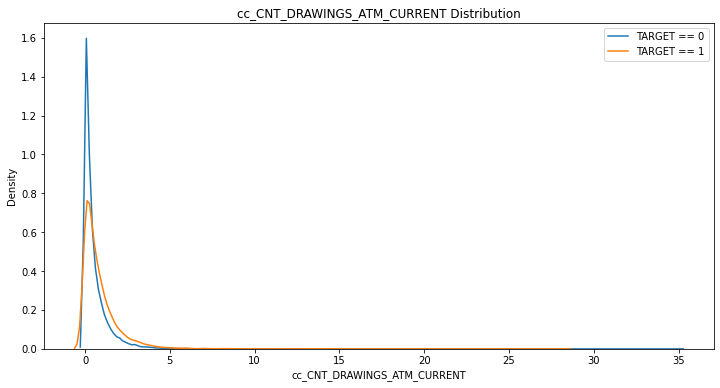

In [52]:
# plot histogram for cc_CNT_DRAWINGS_ATM_CURRENT 
kde_target('cc_CNT_DRAWINGS_ATM_CURRENT', train_data)

The correlation between DAYS_CREDIT and the TARGET is 0.0915
Median value for loan that was not repaid = -835.3810
Median value for loan that was repaid =     -1068.1429


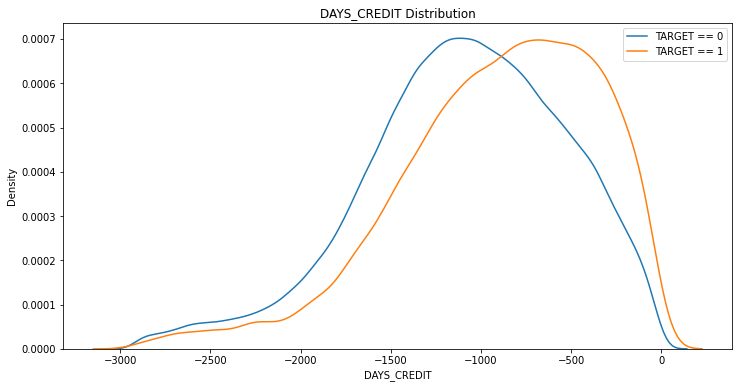

In [53]:
# KDE plot of DAYS_CREDIT
kde_target('DAYS_CREDIT', train_data)

The correlation between NAME_EDUCATION_TYPE_Higher education and the TARGET is -0.0566
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


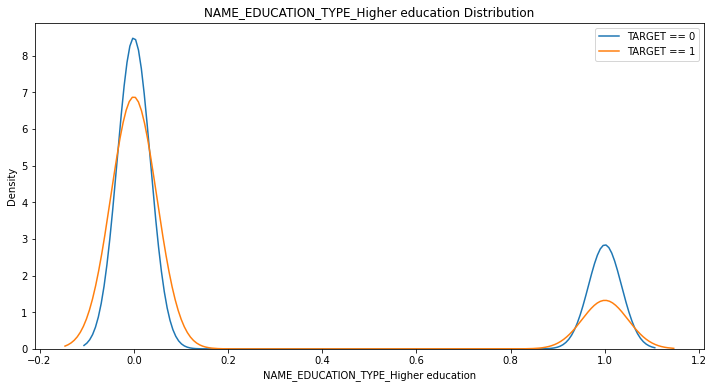

In [54]:
kde_target('NAME_EDUCATION_TYPE_Higher education', train_data)

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553
Median value for loan that was not repaid = 0.3618
Median value for loan that was repaid =     0.5176


/home/lin/.local/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


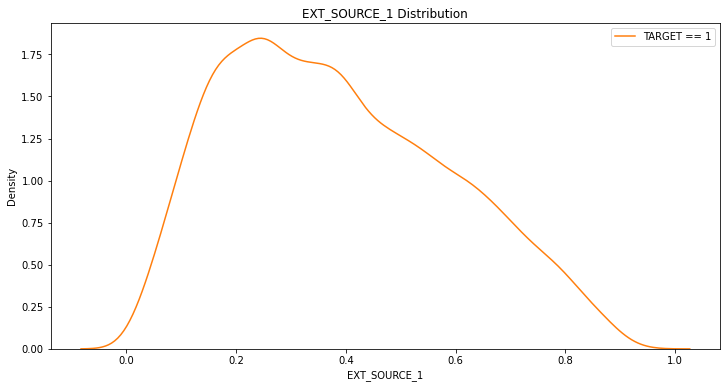

In [55]:
# plot KDE for external sources
kde_target('EXT_SOURCE_1', train_data)

#### Not enough points for the non-default type for external source 1 field

The correlation between pre_DAYS_FIRST_DRAWING and the TARGET is -0.0488
Median value for loan that was not repaid = 365243.0000
Median value for loan that was repaid =     365243.0000


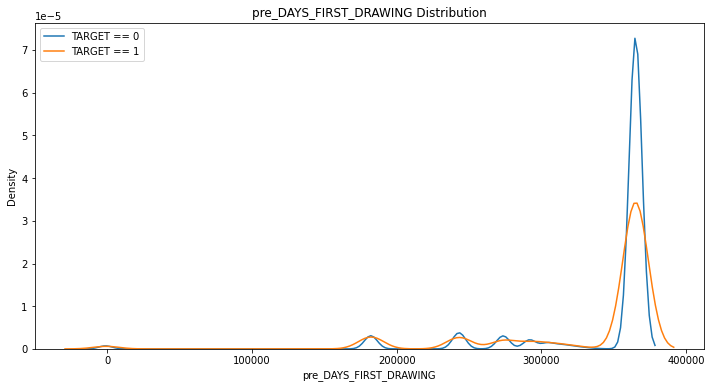

In [56]:
kde_target('pre_DAYS_FIRST_DRAWING', train_data)

#### 2.3.5 check collinearity among variables

In [57]:
# correlation among features
x_x_corr = train_data.corr()['EXT_SOURCE_3'].sort_values()

In [58]:
# display most positive and negative correlations:
print('Most Positive Correlations:\n', x_x_corr.tail(15))
print('Most Negative Correlations:\n', x_x_corr.head(15))

Most Positive Correlations:
 NAME_FAMILY_STATUS_Widow               0.041987
pre_RATE_DOWN_PAYMENT                  0.043155
AMT_CREDIT                             0.043512
AMT_GOODS_PRICE                        0.047713
NAME_HOUSING_TYPE_House / apartment    0.055277
pre_DAYS_FIRST_DRAWING                 0.071760
FLAG_DOCUMENT_6                        0.074971
EXT_SOURCE_2                           0.109166
DAYS_EMPLOYED                          0.113435
NAME_INCOME_TYPE_Pensioner             0.115230
ORGANIZATION_TYPE_XNA                  0.115263
EXT_SOURCE_1                           0.186842
EXT_SOURCE_3                           1.000000
FLAG_MOBIL                                  NaN
FLAG_DOCUMENT_2                             NaN
Name: EXT_SOURCE_3, dtype: float64
Most Negative Correlations:
 DAYS_CREDIT                   -0.401866
bb_MONTHS_BALANCE             -0.342578
DAYS_CREDIT_UPDATE            -0.336995
DAYS_ENDDATE_FACT             -0.237742
DAYS_BIRTH                 

#### It does seem that collinearity exists among features
#### A couple transformations needed: DAYS_BIRTH is in days instead of years, some variables such as DAYS_EMPLOYED have a maximum of over 100 years, this shouldn't be the case.
#### 2.3.6 fix DAYS_BIRTH and DAYS_EMPLOYED variables
#### convert to years

In [59]:
train_data['age'] = round(train_data.DAYS_BIRTH/365, 0)

In [60]:
test_data['age'] = round(test_data.DAYS_BIRTH/365, 0) 

In [61]:
# it seems 365243 is used for nan everywhere in the dataset
train_data.replace(365243, np.nan, inplace= True)

In [62]:
test_data.replace(365243, np.nan, inplace= True)

In [63]:
train_data['yr_employed'] = round(train_data.DAYS_EMPLOYED/365, 1)

In [64]:
test_data['yr_employed'] = round(test_data.DAYS_EMPLOYED/365, 1)

In [79]:
train_data=train_data.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1)
test_data=test_data.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1)
train_data.shape, test_data.shape

((307511, 311), (48744, 310))

In [80]:
train_y = train_data['TARGET']
train_x = train_data.drop(columns=['TARGET','SK_ID_CURR'])
test_x = test_data.drop(columns=['SK_ID_CURR'])

# Part 3 - Develop
### 3.1 feature engineering
#### 3.1.1 impute missing variables

In [81]:
# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(train_x)
# Transform both training and testing data
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

#### 3.1.2 Scale features

In [82]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

#### Given so many features and missing (or imputed) values in our data, we will try random forest then XGBoost which are capable to deal with subset of features and imputed values.
### 3.2 Random Forest

In [83]:
# Initiate the random forest classifier
rf = RandomForestClassifier(n_estimators = 200, max_features = 10, max_depth = 20, min_samples_split = 10, 
                           min_samples_leaf = 2, bootstrap = True, n_jobs=-1,
                           random_state = 42)

In [84]:
# Train on the training data
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [85]:
# Extract feature importances
features = [x for x in train_data.columns if x!='TARGET' and x!='SK_ID_CURR']
feature_importance_values = rf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [86]:
sort_importance = feature_importances.sort_values(by='importance', ascending=False)
print(sort_importance.head(30))

                           feature  importance
26                    EXT_SOURCE_2    0.043915
27                    EXT_SOURCE_3    0.040226
25                    EXT_SOURCE_1    0.018133
123                    DAYS_CREDIT    0.015547
308                    yr_employed    0.014656
133             DAYS_CREDIT_UPDATE    0.013204
163            install_AMT_PAYMENT    0.013157
125            DAYS_CREDIT_ENDDATE    0.012861
7                  DAYS_ID_PUBLISH    0.012672
113              pre_DAYS_DECISION    0.012427
161     install_DAYS_ENTRY_PAYMENT    0.012292
162         install_AMT_INSTALMENT    0.012187
307                            age    0.012042
160        install_DAYS_INSTALMENT    0.012017
167      pos_CNT_INSTALMENT_FUTURE    0.011886
6                DAYS_REGISTRATION    0.011640
75          DAYS_LAST_PHONE_CHANGE    0.011216
115                pre_CNT_PAYMENT    0.011117
105                 pre_AMT_CREDIT    0.011046
118  pre_DAYS_LAST_DUE_1ST_VERSION    0.010963
164          

In [108]:
# Make predictions on the test data
predictions = rf.predict_proba(test_x)[:, 1]
predictions.shape
np.array(app_test['SK_ID_CURR'])

array([100001, 100005, 100013, ..., 456223, 456224, 456250], dtype=int32)

In [109]:
# Make a submission dataframe
submit = pd.DataFrame({'SK_ID_CURR': np.array(app_test['SK_ID_CURR']), 'TARGET':predictions})

pandas.core.frame.DataFrame

In [110]:
submit.to_csv('random_forest_baseline.csv', index = False)

### 3.3 XGBoost

In [116]:
# set up DMatrix for XGBoost
dtrain = xgb.DMatrix(train_x, train_y)
dtest = xgb.DMatrix(test_x)

In [144]:
params = {
    'min_child_weight': 20.0,         # minimum number of finally classified records in one leaf
    'objective': 'binary:logistic',   # our objective is binary classificaiton
    'max_depth': 12,                   # maximum tree depth
    'eta': 0.02,                     # learning rate
    'eval_metric': 'auc',             # area under the curve AUC
    'max_delta_step': 1.8,              # correct metric for train/valid is 20% success
    'colsample_bytree': 0.4,               # engineering features
    'subsample': 0.8,
    'gamma': 0.65
    }

In [145]:
# This will verbose model training progress
watchlist = [(dtrain, 'train')]

In [146]:
XGB_model = xgb.train(params, dtrain, 
                300,                  # numrows
                watchlist,            # to see training performance
                verbose_eval=50) 

[0]	train-auc:0.67612
[50]	train-auc:0.82859
[100]	train-auc:0.84395
[150]	train-auc:0.85562
[200]	train-auc:0.86701
[250]	train-auc:0.87769
[299]	train-auc:0.88695


In [147]:
# Predict on the test data
XGB_pred = XGB_model.predict(dtest)

In [148]:
# Make a submission dataframe
submit_xgb = pd.DataFrame({'SK_ID_CURR': np.array(app_test['SK_ID_CURR']), 'TARGET':XGB_pred})

In [149]:
submit_xgb.to_csv('XGBoost_baseline.csv', index = False)